# **Link with google drive first to save progress!**

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#%matplotlib inline

"""
from PIL import Image
import cv2
import scipy.io as sio
from tqdm import tqdm_notebook, tnrange
from itertools import chain
"""
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2


In [2]:
im_width = 256
im_height = 256

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', kernel_regularizer=l2(.02),  padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal',kernel_regularizer=l2(.02), padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [4]:
def get_unet(input_img, n_filters = 16, dropout = 0.2, batchnorm = True):

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
def train_unet_Easy(X_train, X_valid, y_train, y_valid):

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
    """
    print(X_train.shape)
    print(X_valid.shape)
    print(y_train.shape)
    print(y_valid.shape)
    """
    tensorboard = TensorBoard(log_dir='MASD Segmentation/', write_graph=True, profile_batch=0)
    checkpoint = ModelCheckpoint('MASD Segmentation/weights_Easy.h5',
        monitor='val_loss', save_weights_only=False, save_best_only=True, period=3)
        
    input_img = Input((im_height, im_width, 1), name='img')
   
    model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
    
    model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999), loss="binary_crossentropy", metrics=["accuracy"])
    
    model.summary()
    
    callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint('Unet_sclera.h5', verbose=1), tensorboard, checkpoint]
    
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, callbacks=callbacks ,validation_data=(X_valid, y_valid))
    model.save('Unet_sclera.h5')
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.savefig("Unet.png")
    plt.title('Unet')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_acc'], loc='upper left')   
    plt.show()
    
    return input_img

In [8]:
def load_dataset():
    X_new = []
    y_new = []
    X = np.load("X_256.npy",allow_pickle=True) 
    y = np.load("y_256.npy",allow_pickle=True)
    
    for imgs in range(len(X)):
        X_new.append(X[imgs]/255.0)
        y_new.append(y[imgs]/255.0)
        
    X=np.expand_dims(X_new,axis=3)
    y=np.expand_dims(y_new,axis=3)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [28]:
def test(X_valid, y_valid):
    
    m = load_model("Unet_sclera.h5")
    p=[]
    for imgs in range(10):
        X_pred = X_valid[imgs]
        X_pred=np.expand_dims(X_pred,axis=0)

        X_img= X_valid[imgs]
        X_img=np.expand_dims(X_img,axis=0 )
        y_img= y_valid[imgs]
        y_img=np.expand_dims(y_img,axis=0)
     
        pred= m.predict(X_pred)
          
        pred = np.squeeze(pred)
        
        X_img=np.squeeze(X_img)
        y_img=np.squeeze(y_img)

        #p = np.resize(pred,(418,100))
        p.append(pred)

        #X_test = np.squeeze(X_test)
        #X_test1 = np.resize(X_test,(418,100))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(X_img)
        ax1.set_xlabel('Image')
        ax2.imshow(y_img)
        ax2.set_xlabel('Sclera')
        ax3.imshow(pred)
        ax3.set_xlabel('Prediction')
        plt.show()


        
    return p

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

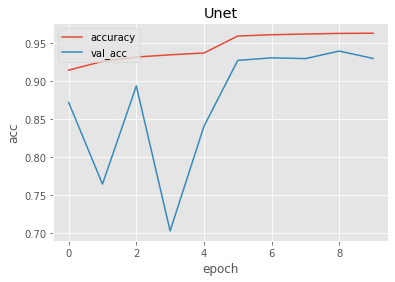

TypeError: ignored

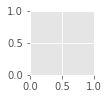

In [10]:
X_train, X_valid, y_train, y_valid = load_dataset()
inputimg = train_unet_Easy(X_train, X_valid, y_train, y_valid)


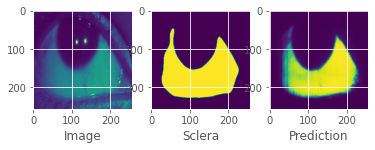

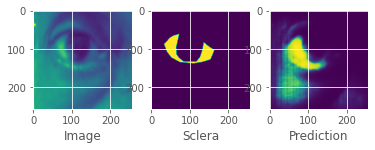

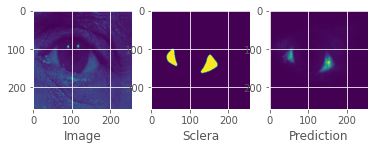

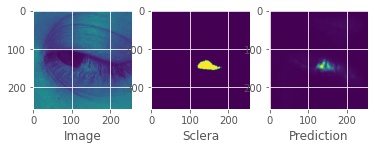

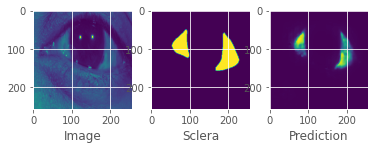

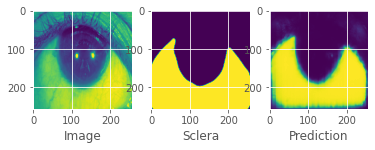

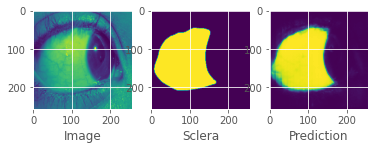

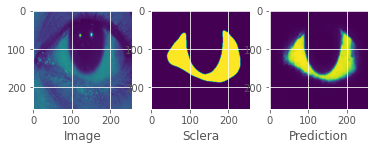

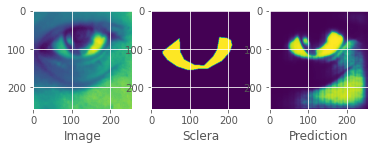

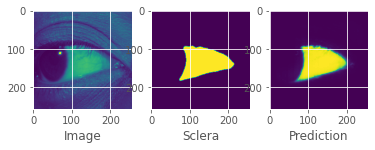

In [29]:
p=test(X_valid,y_valid)